<a href="https://colab.research.google.com/github/jalca014/profitable_app_profiles_dataquest/blob/main/node2vec_DadditNetworkFixed_SGDClassifier(Log).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NOTE: Make sure DadditNetwork.gml and sub_labeled_users.json are in the proper google drive folders so that you can import them from there.
# Node classification with Node2Vec


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/node2vec-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/node2vec-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

## Introduction

An example of node classification on a homogeneous graph using the `Node2Vec` representation learning algorithm. The example uses components from the `stellargraph`, `Gensim`, and `scikit-learn` libraries.

**Note:** For clarity of exposition, this notebook forgoes the use of standard machine learning practices such as `Node2Vec` parameter tuning, node feature standarization, data splitting that handles class imbalance, classifier selection, and classifier tuning to maximize predictive accuracy. We leave such improvements to the reader.

### References

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

[2] Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

[3] Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

[4] scikit-learn: Machine Learning in Python ([link](http://scikit-learn.org/stable/))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import matplotlib.pyplot as plt # for plotting things

from sklearn.manifold import TSNE # a projecting algorithm
from sklearn.model_selection import train_test_split # standard train test split
from sklearn.linear_model import LogisticRegressionCV # know what this is
from sklearn.metrics import accuracy_score # know what this is

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk # this helps us run node2vec
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

## Datasets

For clarity, we use only the largest connected component, ignoring isolated nodes and subgraphs; having these in the data does not prevent the algorithm from running and producing valid results.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
features = pd.read_json('/content/drive/Shareddrives/Papers/Daddit stuff/sub_labeled_users.json')
features.index = features['author']
print(features.head())
features.drop(labels='[deleted]',inplace=True)



                                author  MRAD  MLD  allint
author                                                   
-----username-----  -----username-----     0    0       0
----_____----            ----_____----     0    0       0
---Bokonon---            ---Bokonon---     0    0       0
--0o0o0--                    --0o0o0--     0    0       0
--BMO--                        --BMO--     1    0       1


In [6]:
len(features[features["MRAD"] == 1])

7322

In [7]:
len(features[features["MRAD"] == 0])

66481

In [5]:
# dataset = datasets.Cora()
datasetn = nx.read_gml('/content/drive/Shareddrives/Papers/Daddit stuff/DadditNetworkFixed.gml') # fair warning: this may take a while to upload
dataset1 = StellarGraph.from_networkx(
    datasetn, edge_type_default="responded_to", node_features=features[["MRAD","MLD"]]
    )
# G, node_subjects = dataset.load(largest_connected_component_only=True)

KeyboardInterrupt: ignored

In [7]:
print(dataset1.info())

StellarGraph: Undirected multigraph
 Nodes: 73803, Edges: 2871160

 Node types:
  default: [73803]
    Features: float32 vector, length 2
    Edge types: default-responded_to->default

 Edge types:
    default-responded_to->default: [2871160]
        Weights: all 1 (default)
        Features: none


In [8]:
node_subjects = features['author']
node_subjects.head()

author
-----username-----    -----username-----
----_____----              ----_____----
---Bokonon---              ---Bokonon---
--0o0o0--                      --0o0o0--
--BMO--                          --BMO--
Name: author, dtype: object

Have a graph of the daddit network, now just want to add node names and see if I can implement the relationships here.

## The Node2Vec algorithm

The Node2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are,

1. Use second-order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [2], is used for calculating the embedding vectors.


## Corpus generation using random walks

The stellargraph library provides an implementation for second-order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`. See [1] for a detailed description of these parameters. 

We are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 and `q` to 2.0.

In [9]:
%%time

rw = BiasedRandomWalk(dataset1)

walks = rw.run(
    nodes=list(dataset1.nodes()),  # root nodes
    length=20,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=False,
    seed=42,
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 369015
CPU times: user 22min 29s, sys: 2.76 s, total: 22min 31s
Wall time: 22min 34s


## Representation Learning using Word2Vec

We use the `Word2Vec` [2], implementation in the free Python library `Gensim` [3], to learn representations for each node in the graph. It works with `str` tokens, but the graph has integer IDs, so they're converted to `str` here.

We set the dimensionality of the learned embedding vectors to 128 as in [1].

In [10]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks] # constructs a list of our random walks as a list of lists
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

# Look up gensim saving models https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# model.wv["19231"].shape

## Visualise Node Embeddings

We retrieve the `Word2Vec` node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [11]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
print(node_ids[:5])

node_targets = node_subjects[[node_id for node_id in node_ids]] # setting up the node targets
# try removing the int() from around node_id and see if that helps?

['FifthRendition', 'raphtze', 'crazytr', 'clunkclunk', 'GronamTheOx']


In [12]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2) # defines the transformation down to 2 dimensions
node_embeddings_2d = tsne.fit_transform(node_embeddings) # actually does the transformation

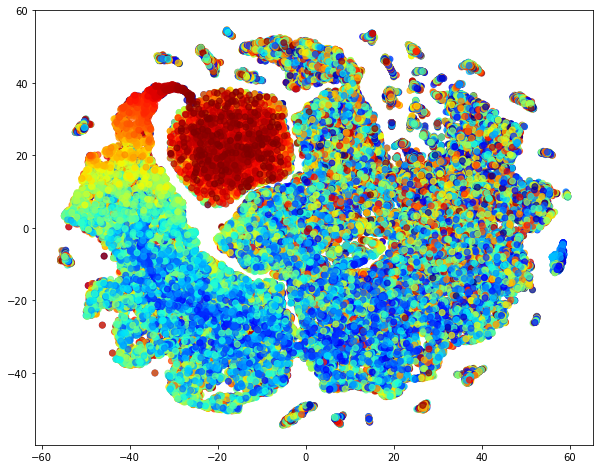

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))} # enumerates l over the unique node targets
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

One thing to try: Yellowbrick here: https://www.kdnuggets.com/2019/09/python-libraries-interpretable-machine-learning.html

## Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node attribute inference. 

In this example, we will use the `Node2Vec` node embeddings to train a classifier to predict the subject of a paper in Cora.

Instead of 1 predict, loop over X_test, dividing into a hundred different

In [12]:
from sklearn.preprocessing import StandardScaler

X = node_embeddings

sc = StandardScaler()
X_rescaled = sc.fit_transform(X)
# y holds the corresponding target values
y = np.array(node_targets)

To try here: random undersampling, esp since about 9% of data is target. Might see low precision or recall or whatever. Creates more balance.

Also, do the scaling after!!

To do:

Random undersampling, then x_test/y_test, then scaling: scale train and test separately.

Then run sgd and do the fun stuff.

For visualization, try:
Yellowbrick: https://www.scikit-yb.org/en/latest/api/text/tsne.html

Mess around with node colors in original thing.

Later: some intro lectures and things on networks. ie Density, connectedness.

### Data Splitting

We split the data into train and test sets. 

We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_rescaled, y, train_size=None, test_size=None)

In [14]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (55352, 128)
 y_train = (55352,)
 X_test = (18451, 128)
 y_test = (18451,)


### Classifier Training

We train a Logistic Regression classifier on the training data via SGD.

In [15]:
from sklearn.linear_model import SGDClassifier
from joblib import dump, load

# clf = SGDClassifier(loss='log',penalty='l2',random_state=5343)
clf = load('SGDLogClassifier.joblib') 

class_array = np.unique(y)

In [ ]:
%%time

clf.partial_fit(X_train, y_train,classes=class_array)

CPU times: user 2h 23min 12s, sys: 9.1 s, total: 2h 23min 21s
Wall time: 2h 22min 58s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=5343, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=5343)

#clf = LogisticRegressionCV(
#    Cs=10, cv=3, tol=0.01, scoring="accuracy", verbose=False, multi_class="ovr", random_state=5343, max_iter=1000, # max_iter has been upped to 1000 from 100 to try and address the error
#)
clf.fit(X_train, y_train)
# removed cv to see if that deal with this error:
# ValueError: n_splits=2 cannot be greater than the number of members in each class.

In [ ]:
# partial fit for SGD classifier https://scikit-learn.org/0.15/modules/scaling_strategies.html
# or try perceptron, partial fit also works here (need to say how to partial it is, use batches)
# check out this too: https://scikit-learn.org/stable/modules/model_persistence.html
# look into naive bayes
# label the nodes somehow or understand what the colors mean
# also try to look at top 500

In [ ]:
from joblib import dump, load
dump(clf, 'SGDLogClassifier.joblib')

['SGDLogClassifier.joblib']

Predict the hold out test set.

In [ ]:
%%time

y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [ ]:
accuracy_score(y_test, y_pred)

0.8344051446945338